In [1]:
import pandas as pd
import json
import random
import numpy as np
import matplotlib.pyplot as plt

# 1. Create Product_Info table

Schema:

<img src="Schema Images\Schema_Product_Info.jpg" alt="product_info_schema_diagram" style="width: 200px;"/>

Source for the columns:

* ProductSKU $\hspace{1em}$   = Generate an unique ID for every Description x VolumneSize combination
* Description $\hspace{1.15em}$   = BegInvFINAL12312016 + EndInvFINAL12312016 + SalesFINAL12312016 + PurchasesFINAL12312016
* VolumneSize $\hspace{0.6em}$   = BegInvFINAL12312016 + EndInvFINAL12312016 + SalesFINAL12312016 + PurchasesFINAL12312016
* AlcoholType $\hspace{0.75em}$   = AlcoholType
* ABV        $\hspace{3.65em}$    = AlcoholABV
* FlavorProfile $\hspace{0.65em}$  = AlcoholFlavorProfile

## Combine product description and volume sources

In [2]:
df_purchase= pd.read_csv("2017PurchasePricesDec.csv")
df_purchase= df_purchase[['Description','Size','Classification']].drop_duplicates(keep='first')
display(df_purchase.sample(3))

,Description,Size,Classification
8089,Vincent Van Gogh Mango Vodka,750mL,1
5351,Riunite Bianco,1500mL,2
3783,Bota Mini Pnt Grigio,500mL,2


In [3]:
df_purchase2= pd.read_csv("PurchasesFINAL12312016.csv")
df_purchase2= df_purchase2[['Description','Size','Classification']].drop_duplicates(keep='first')
df_purchase2.head(3)

,Description,Size,Classification
0,Tequila Ocho Plata Fresno,750mL,1
1,TGI Fridays Ultimte Mudslide,1.75L,1
2,TGI Fridays Long Island Iced,1.75L,1


In [4]:
df_sales= pd.read_csv("SalesFINAL12312016.csv")
df_sales= df_sales[['Description','Size','Classification']].drop_duplicates(keep='first')
df_sales.head(3)

,Description,Size,Classification
0,Jim Beam w/2 Rocks Glasses,750mL,1
4,Maker's Mark Combo Pack,375mL 2 Pk,1
8,F Coppola Dmd Ivry Cab Svgn,750mL,2


In [5]:
#Combine inventory tables and extract unique product
df_start_inv= pd.read_csv("BegInvFINAL12312016.csv")
df_start_inv= df_start_inv[['Description','Size']].drop_duplicates(keep='first')
df_start_inv['Classification']= None
df_start_inv.head(3)

,Description,Size,Classification
0,Gekkeikan Black & Gold Sake,750mL,None
1,Canadian Club 1858 VAP,750mL,None
2,Herradura Silver Tequila,750mL,None


In [6]:
df_end_inv= pd.read_csv("EndInvFINAL12312016.csv")
df_end_inv= df_end_inv[['Description','Size']].drop_duplicates(keep='first')
df_end_inv['Classification']= None
df_end_inv.head(3)

,Description,Size,Classification
0,Gekkeikan Black & Gold Sake,750mL,None
1,Herradura Silver Tequila,750mL,None
2,Herradura Reposado Tequila,750mL,None


In [7]:
df_products= pd.concat([df_purchase, df_purchase2, df_sales,df_start_inv,df_end_inv])
df_products= df_products.drop_duplicates(subset=['Description'], keep='first')
df_products.sample(5)

,Description,Size,Classification
2843,F Coppola Rosso Bianco Rosso,750mL,2
4459,Domino Cab Svgn,750mL,2
8286,El Conquistador Anejo,750mL,1
8890,Veuve Clicquot Ylw Ice Lettr,750mL,2
10502,Storypoint Cab Svgn,750mL,2


In [8]:
# Check for nulls
df_products.isna().sum()

Description         1
Size                1
Classification    280
dtype: int64

In [9]:
# Handle Nulls
df_products.dropna(subset=['Size','Description'], inplace=True)
df_products.Classification= df_products.Classification.fillna('Ukn')
df_products.isna().sum()

Description       0
Size              0
Classification    0
dtype: int64

## Create VolumeSize column

In [10]:
# Load size-volume mapping dictionary
f = open('Resources\Product_Size_Volume_Mapping.json')
size_vol_mapping_dict= json.load(f)

# Replace the size column with VolumeSize
df_products['Size']= df_products['Size'].replace(size_vol_mapping_dict)
df_products.rename(columns= {'Size':"VolumeSize"},inplace=True)
df_products.sample(5)

,Description,VolumeSize,Classification
4174,Fuki Plum Wine,750.0,2
2976,Frei Bros RSV Chard RRV,750.0,2
2337,Antinori Villa Chianti Class,750.0,2
2444,Barefoot Cellars Malbec,1500.0,2
846,Absolut Spark Vodka,750.0,1


In [11]:
df_products.VolumeSize.unique()

array([  750. ,  1000. ,  1750. ,    50. ,   375. ,   400. ,   250. ,
         200. ,   150. ,   300. ,   800. ,  1500. ,  3000. ,  5000. ,
        4000. ,   748. ,   100. ,   187. ,   500. ,   720. ,   650. ,
         600. ,   330. ,   180. , 18000. ,  2000. ,  4500. ,  6000. ,
       20000. ,  2250. ,  1125. ,   561. ,   162.5,  1100. , 19500. ,
         560. ,  3750. ,  9000. ])

## Generate ProductSKU column

ProductSKU is a 5 digit unique number

In [12]:
# Generate and assign a 5 digit number 
df_products= df_products.sort_values(by='Description')
df_products['ProductSKU'] = [i for i in range(1000, 1000+len(df_products))]
df_products.reset_index(drop=True, inplace=True)
df_products.sample(5)

,Description,VolumeSize,Classification,ProductSKU
9271,Schmitt Sohne Relax Mosel,1500.0,2,10271
5499,Jack Daniel BTB NE Tap House,750.0,1,6499
3771,Duboeuf Bjls Nouveau 2014,750.0,2,4771
849,Barrow's Intense Ginger,375.0,1,1849
1548,C Y Toro Gran Rsva Carmenere,750.0,2,2548


In [13]:
#Check for duplicate ProductSKU
df_products.duplicated('ProductSKU').any()

False

## Create Alcohol Type column

In [14]:
df_products2 = df_products.copy()

In [15]:
# Read data
df_a_type= pd.read_excel("AlcoholType.xlsx")
print("Shape before dropping duplicates:",df_a_type.shape)

# Drop duplicates
df_a_type= df_a_type.drop_duplicates(subset=['product_name'], keep='first')
print("Shape after dropping duplicates:",df_a_type.shape)
df_a_type.head(3)

Shape before dropping duplicates: (9841, 3)
Shape after dropping duplicates: (7157, 3)


,product_id,product_name,alcohol_type
0,0,Zardetto Private Cuvee Glara,The alcoholic type of Zardetto Private Cuvée i...
1,1,Dalwhinnie 25 Yr Single Malt,Whiskey
2,2,Bouza Temp Tannat,Wine


In [16]:
# Format alcohol_type column to only contain type categories

def correct_a_type(type):
    type= type.lower()
    for i in ["whiskey", "vodka", "rum", "tequila", "gin", "liqueurs", "wine", "beer", "cider", "non alcoholic", "others"]:
        if(i in type):
            return (i.title())
    return 'Others'
        
df_a_type['alcohol_type'] = df_a_type['alcohol_type'].apply(correct_a_type)
df_a_type.alcohol_type.value_counts()

Wine        5048
Whiskey      584
Liqueurs     344
Others       311
Vodka        303
Rum          222
Tequila      187
Gin           79
Beer          49
Cider         30
Name: alcohol_type, dtype: int64

In [17]:
# Join tables
df_products2= pd.merge(df_products2, df_a_type, how='left', left_on=['Description'], right_on=['product_name'])
df_products2= df_products2[['ProductSKU','Description','VolumeSize','alcohol_type','Classification']]
df_products2


,ProductSKU,Description,VolumeSize,alcohol_type,Classification
0,1000,(RI) 1,750.0,Others,1
1,1001,.nparalleled Svgn Blanc,750.0,NaN,2
2,1002,10 Cane Rum,750.0,NaN,1
3,1003,10 Span Cab Svgn CC,750.0,Wine,2
4,1004,10 Span Chard CC,750.0,NaN,2
...,...,...,...,...,...
11389,12389,Zum Rsl,750.0,Rum,2
11390,12390,Zwack Liqueur,750.0,NaN,1
11391,12391,Zygo Mixed Citrus Vodka,750.0,Vodka,1
11392,12392,g Sake,300.0,NaN,2


In [18]:
# Check nulls
df_products2.isna().sum()

ProductSKU           0
Description          0
VolumeSize           0
alcohol_type      4237
Classification       0
dtype: int64

In [19]:
# Handle nulls
df_products2['alcohol_type'].fillna('Others', inplace=True)
df_products2.sample(5)

,ProductSKU,Description,VolumeSize,alcohol_type,Classification
408,1408,Antinori Badia Chianti Clsc,750.0,Wine,2
3040,4040,Coole Swan Irish Cream,750.0,Liqueurs,1
7922,8922,P & J Cold Soaked Pineapples,750.0,Rum,1
2124,3124,Ch Bellevue Mondotte 10 Brdx,750.0,Wine,2
10352,11352,The Naked Grape Box Harvest,3000.0,Wine,2


## Create Flavor Profile column

In [20]:
df_products3 = df_products2.copy()

In [21]:
# Read data
df_a_type= pd.read_excel("Flavor_profile.xlsx")
print("Shape before dropping duplicates:",df_a_type.shape)

# Drop duplicates
df_a_type= df_a_type.drop_duplicates(subset=['product_name'], keep='first')
print("Shape after dropping duplicates:",df_a_type.shape)
df_a_type.head(3)

Shape before dropping duplicates: (9844, 3)
Shape after dropping duplicates: (7118, 3)


,product_id,product_name,flavor
0,0,Zardetto Private Cuvee Glara,Fruity
1,1,Dalwhinnie 25 Yr Single Malt,Floral
2,4,Red Autumn Red,Fruity


In [22]:
# Format alcohol_type column to only contain type categories

def correct_flavor(type):
    type= type.lower()
    for i in ["fruity", "spicy", "herbal", "floral", "sweet", "bitter", "sour", "savory", "other"]:
        if(i in type):
            return (i.title())
    return 'Others'
        
df_a_type['flavor'] = df_a_type['flavor'].apply(correct_flavor)
df_a_type.flavor.value_counts()

Fruity    4938
Sweet      621
Herbal     451
Other      276
Floral     273
Others     260
Spicy      176
Savory      46
Sour        41
Bitter      36
Name: flavor, dtype: int64

In [23]:
# Join tables
df_products3= pd.merge(df_products3, df_a_type, how='outer', left_on=['Description'], right_on=['product_name'])
df_products3= df_products3[['ProductSKU','Description','VolumeSize','alcohol_type', 'flavor','Classification']]
df_products3

,ProductSKU,Description,VolumeSize,alcohol_type,flavor,Classification
0,1000,(RI) 1,750.0,Others,Other,1
1,1001,.nparalleled Svgn Blanc,750.0,Others,NaN,2
2,1002,10 Cane Rum,750.0,Others,NaN,1
3,1003,10 Span Cab Svgn CC,750.0,Wine,NaN,2
4,1004,10 Span Chard CC,750.0,Others,Fruity,2
...,...,...,...,...,...,...
11389,12389,Zum Rsl,750.0,Rum,Others,2
11390,12390,Zwack Liqueur,750.0,Others,Herbal,1
11391,12391,Zygo Mixed Citrus Vodka,750.0,Vodka,Fruity,1
11392,12392,g Sake,300.0,Others,NaN,2


In [24]:
# Check nulls 
df_products3.isna().sum()

ProductSKU           0
Description          0
VolumeSize           0
alcohol_type         0
flavor            4276
Classification       0
dtype: int64

In [25]:
# Handle nulls
df_products3['flavor'].fillna('Others', inplace=True)
display(df_products3.sample(5))
df_products3.isna().any()

,ProductSKU,Description,VolumeSize,alcohol_type,flavor,Classification
671,1671,Bacardi Party Drinks Rum Run,1750.0,Rum,Others,1
11350,12350,Zerran Tinto Montsant,750.0,Wine,Others,2
11125,12125,White Knight Viognier,750.0,Wine,Floral,2
10316,11316,The Glenlivet Founders Res,750.0,Whiskey,Fruity,1
9639,10639,Smoking Loon Pnt Grigio Cal,750.0,Others,Fruity,2


ProductSKU        False
Description       False
VolumeSize        False
alcohol_type      False
flavor            False
Classification    False
dtype: bool

## Create Alcohol ABV column

In [26]:
df_products4 = df_products3.copy()

In [27]:
# Read data
df_a_type= pd.read_excel("Final Raw Data\AlcoholABV.xlsx")
print("Shape before dropping duplicates:",df_a_type.shape)

# Drop duplicates
df_a_type= df_a_type.drop_duplicates(subset=['product_name'], keep='first')
print("Shape after dropping duplicates:",df_a_type.shape)
df_a_type.head(3)

Shape before dropping duplicates: (9841, 3)
Shape after dropping duplicates: (9841, 3)


,product_id,product_name,abv
0,0,Knob Creek 2001 Bourbon,50.5
1,1,The Divining Rod Pinot Noir,14.5
2,2,Livon Pnt Grigio,13.0


In [28]:
# Join tables
df_products4= pd.merge(df_products4, df_a_type, how='outer', left_on=['Description'], right_on=['product_name'])
df_products4= df_products4[['ProductSKU','Description','VolumeSize','alcohol_type', 'flavor','abv','Classification']]
df_products4

,ProductSKU,Description,VolumeSize,alcohol_type,flavor,abv,Classification
0,1000,(RI) 1,750.0,Others,Other,1.0,1
1,1001,.nparalleled Svgn Blanc,750.0,Others,Others,NaN,2
2,1002,10 Cane Rum,750.0,Others,Others,NaN,1
3,1003,10 Span Cab Svgn CC,750.0,Wine,Others,0.0,2
4,1004,10 Span Chard CC,750.0,Others,Fruity,13.5,2
...,...,...,...,...,...,...,...
11389,12389,Zum Rsl,750.0,Rum,Others,NaN,2
11390,12390,Zwack Liqueur,750.0,Others,Herbal,40.0,1
11391,12391,Zygo Mixed Citrus Vodka,750.0,Vodka,Fruity,35.0,1
11392,12392,g Sake,300.0,Others,Others,NaN,2


In [29]:
# Check nulls 
df_products4.isna().sum()

ProductSKU           0
Description          0
VolumeSize           0
alcohol_type         0
flavor               0
abv               1931
Classification       0
dtype: int64

In [30]:
# Replace nulls with mean
df_products4['abv'].fillna(np.mean(df_products4[~df_products4['abv'].isna()].abv), inplace=True)
display(df_products4.sample(5))
df_products4.isna().any()

,ProductSKU,Description,VolumeSize,alcohol_type,flavor,abv,Classification
2416,3416,Ch Montelena Cab Svgn 2006,750.0,Wine,Fruity,13.900000,2
2998,3998,Condes de Albarei Albarino,750.0,Others,Others,19.428218,2
3372,4372,DeKuyper Peppermint,1000.0,Others,Others,22.000000,1
5281,6281,Hornitos Plata Glass Pack,750.0,Tequila,Others,40.000000,Ukn
2754,3754,Christian Bros Dry Sherry,750.0,Others,Others,18.000000,2


ProductSKU        False
Description       False
VolumeSize        False
alcohol_type      False
flavor            False
abv               False
Classification    False
dtype: bool

## Check outliers

In [31]:
df_product_info= df_products4.copy()
display(df_product_info.sample(5))
df_product_info.isna().any().any()

,ProductSKU,Description,VolumeSize,alcohol_type,flavor,abv,Classification
2637,3637,Chapelle de Bastion Picpoul,750.0,Wine,Fruity,13.5,2
5258,6258,Honig Late Harvest Svgn Bl,375.0,Wine,Sweet,14.0,2
3876,4876,Effen Vodka,750.0,Vodka,Other,40.0,1
11191,12191,William Grant Scotch,750.0,Whiskey,Herbal,40.0,1
1655,2655,Calypso Spiced Rum,1750.0,Rum,Spicy,35.0,1


False

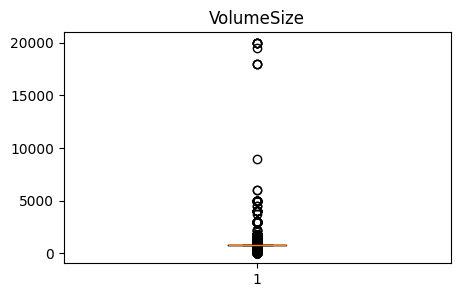

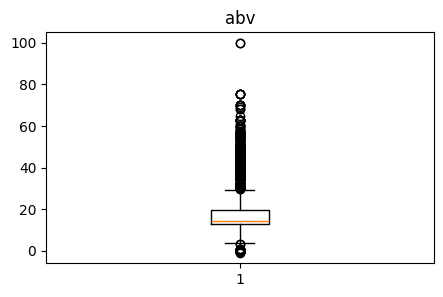

In [32]:
for i in ['VolumeSize','abv']:
    plt.figure(figsize=(5, 3))
    plt.boxplot(df_product_info[i])
    plt.title(i)
    plt.show()

## Verification

In [33]:
# Check datatype
df_product_info.dtypes

ProductSKU          int64
Description        object
VolumeSize        float64
alcohol_type       object
flavor             object
abv               float64
Classification     object
dtype: object

In [34]:
# Correct Datatypes
df_product_info.ProductSKU= df_product_info.ProductSKU.astype(object)
df_product_info.dtypes

ProductSKU         object
Description        object
VolumeSize        float64
alcohol_type       object
flavor             object
abv               float64
Classification     object
dtype: object

In [35]:
# Rename and arrange column
df_product_info.rename(columns={'alcohol_type':"AlcoholType",
                                "flavor":"FlavorProfile",
                                "abv":"ABV"}, inplace=True)
df_product_info

,ProductSKU,Description,VolumeSize,AlcoholType,FlavorProfile,ABV,Classification
0,1000,(RI) 1,750.0,Others,Other,1.000000,1
1,1001,.nparalleled Svgn Blanc,750.0,Others,Others,19.428218,2
2,1002,10 Cane Rum,750.0,Others,Others,19.428218,1
3,1003,10 Span Cab Svgn CC,750.0,Wine,Others,0.000000,2
4,1004,10 Span Chard CC,750.0,Others,Fruity,13.500000,2
...,...,...,...,...,...,...,...
11389,12389,Zum Rsl,750.0,Rum,Others,19.428218,2
11390,12390,Zwack Liqueur,750.0,Others,Herbal,40.000000,1
11391,12391,Zygo Mixed Citrus Vodka,750.0,Vodka,Fruity,35.000000,1
11392,12392,g Sake,300.0,Others,Others,19.428218,2


In [36]:
# Reorder Columns
df_product_info= df_product_info[['ProductSKU','Description','VolumeSize','AlcoholType','ABV','FlavorProfile','Classification']]

In [37]:
# Veify primary key
df_product_info['ProductSKU'].value_counts()

1000     1
8610     1
8590     1
8591     1
8592     1
        ..
4800     1
4801     1
4802     1
4803     1
12393    1
Name: ProductSKU, Length: 11394, dtype: int64

In [38]:
df_product_info.to_excel('Product_Info.xlsx', index= False)

# 2. Create Vendor_Info table

Schema:

<img src="Schema Images\Schema_Vendor_Info.jpg" alt="product_info_schema_diagram" style="width: 200px;"/>

Source for the columns:

* VendorNumber $\hspace{0.4em}$   = 2017PurchasePricesDec
* VendorName $\hspace{1.15em}$   = 2017PurchasePricesDec

In [39]:
df_vendor_info= pd.read_csv('2017PurchasePricesDec.csv')
df_vendor_info.sample(3)

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
7651,21211,Hugo Rose Sparkling,14.99,750mL,750,2,10.27,90024,VINILANDIA USA
1590,8092,Johnnie Walker Red Label,2.29,50mL,50,1,1.70,3960,DIAGEO NORTH AMERICA INC
12181,27747,Mayacamas 14 Chardonnay Mt V,44.99,750mL,750,2,31.03,9552,M S WALKER INC


In [40]:
df_vendor_info= df_vendor_info[['VendorNumber','VendorName']].value_counts().reset_index(drop=False)[['VendorNumber','VendorName']]
df_vendor_info.drop_duplicates(subset=['VendorNumber'], keep= 'first', inplace=True)
df_vendor_info.sample(5)

,VendorNumber,VendorName
66,3089,SIDNEY FRANK IMPORTING CO
55,1601,VRANKEN AMERICA
22,1128,BROWN-FORMAN CORP
115,90052,HAUNTING WHISPER VYDS
36,8352,LUXCO INC


In [41]:
df_vendor_info.shape

(131, 2)

In [42]:
# Correct Datatype
df_vendor_info= df_vendor_info.astype(object)
df_vendor_info.dtypes

VendorNumber    object
VendorName      object
dtype: object

In [43]:
# Verify Primary Key
df_vendor_info.VendorNumber.value_counts()

4425     1
90056    1
28776    1
1273     1
2496     1
        ..
90011    1
3924     1
8352     1
1650     1
90033    1
Name: VendorNumber, Length: 131, dtype: int64

In [44]:
df_vendor_info.to_excel('Vendor_Info.xlsx', index= False)

# 3. Create Store_Info table

Schema:

<img src="Schema Images\Schema_Store_Info.jpg" alt="product_info_schema_diagram" style="width: 200px;"/>

Source for the columns:

* StoreID $\hspace{0.0em}$   = BegInvFINAL12312016.csv + EndInvFINAL12312016.csv
* City $\hspace{1.3em}$   = BegInvFINAL12312016.csv + EndInvFINAL12312016.csv

In [45]:
#Combine inventory tables and extract Store info
df_start_inv= pd.read_csv("BegInvFINAL12312016.csv")
df_start_inv= df_start_inv[['Store','City']].drop_duplicates(keep='first')
df_start_inv.head(3)

df_end_inv= pd.read_csv("EndInvFINAL12312016.csv")
df_end_inv= df_end_inv[['Store','City']].drop_duplicates(keep='first')
df_end_inv.head(3)

df_store_info= pd.concat([df_start_inv,df_end_inv])
df_store_info= df_store_info.drop_duplicates(subset=['Store'], keep='first')
print(df_store_info.shape)
df_store_info.sample(5)

(80, 2)


,Store,City
49890,22,SHARNWICK
66660,30,CULCHETH
52277,23,ARBINGTON
78360,34,PITMERDEN
42701,19,WINTERVALE


In [46]:
# FIx data types
df_store_info.Store= df_store_info.Store.astype(object)
df_store_info.dtypes

Store    object
City     object
dtype: object

In [47]:
# Verify Primary Key
df_store_info.Store.value_counts()

1     1
2     1
59    1
58    1
57    1
     ..
26    1
25    1
24    1
23    1
81    1
Name: Store, Length: 80, dtype: int64

In [48]:
df_store_info.rename(columns= {'Store':'StoreID'}, inplace=True)
df_store_info.sample(3)

,StoreID,City
168669,68,SOLARIS
182801,72,HARDERSFIELD
100665,42,BLACK HOLLOW


In [49]:
df_store_info.to_excel('Store_Info.xlsx', index= False)

# 4. Create Begin_End_Inventory table

Schema:

<img src="Schema Images\Schema_Beign_End_Inventory.jpg" alt="product_info_schema_diagram" style="width: 200px;"/>

Source for the columns:

* Date $\hspace{3.5em}$   = BegInvFINAL12312016.csv + EndInvFINAL12312016.csv
* StoreID $\hspace{2.5em}$   = Store_Info.csv
* Brand $\hspace{3em}$ = BegInvFINAL12312016.csv + EndInvFINAL12312016.csv
* InventorySize $\hspace{0.3em}$ = BegInvFINAL12312016.csv + EndInvFINAL12312016.csv

In [50]:
#Combine inventory tables and extract Store info
df_start_inv= pd.read_csv("BegInvFINAL12312016.csv")
df_start_inv= df_start_inv[['startDate','Store','Brand','onHand']]
df_start_inv.rename(columns= {"startDate":"Date", "Store":"StoreID","onHand":"InventorySize"}, inplace=True)
display(df_start_inv.head(3))

df_end_inv= pd.read_csv("EndInvFINAL12312016.csv")
df_end_inv= df_end_inv[['endDate','Store','Brand','onHand']]
df_end_inv.rename(columns={"endDate":"Date", "Store":"StoreID","onHand":"InventorySize"}, inplace=True)
display(df_end_inv.head(3))

df= pd.concat([df_start_inv,df_end_inv])
print(df.shape)
df.sample(5)

,Date,StoreID,Brand,InventorySize
0,2016-01-01,1,58,8
1,2016-01-01,1,60,7
2,2016-01-01,1,62,6


,Date,StoreID,Brand,InventorySize
0,2016-12-31,1,58,11
1,2016-12-31,1,62,7
2,2016-12-31,1,63,7


(431018, 4)


,Date,StoreID,Brand,InventorySize
116068,2016-12-31,47,5368,17
173499,2016-01-01,69,4160,66
197553,2016-01-01,76,19357,24
83690,2016-01-01,34,36894,13
49219,2016-12-31,21,8553,10


In [51]:
#Check nulls
df.isna().any()

Date             False
StoreID          False
Brand            False
InventorySize    False
dtype: bool

In [52]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.date
df.Date.unique()

array([datetime.date(2016, 1, 1), datetime.date(2016, 12, 31)],
      dtype=object)

In [53]:
# Fix datatypes
df.StoreID= df.StoreID.astype(object)
df.Brand= df.Brand.astype(object)
df.dtypes

Date             object
StoreID          object
Brand            object
InventorySize     int64
dtype: object

In [54]:
# Check primary keys

df[['Date','StoreID','Brand']].value_counts().reset_index()

,Date,StoreID,Brand,0
0,2016-01-01,1,58,1
1,2016-12-31,34,3709,1
2,2016-12-31,34,3763,1
3,2016-12-31,34,3762,1
4,2016-12-31,34,3761,1
...,...,...,...,...
431013,2016-01-01,60,567,1
431014,2016-01-01,60,555,1
431015,2016-01-01,60,543,1
431016,2016-01-01,60,540,1


In [55]:
df.to_excel('Begin_End_Inventory.xlsx', index= False)

# 5. Create Purchase_Order_Deivery_History

Schema:

<img src="Schema Images\Schema_PD_Delivery_Info.jpg" alt="Schema_diagram" style="width: 200px;"/>

Source for the columns:
* PurchasesFINAL12312016.csv

In [11]:
df= pd.read_csv('PurchasesFINAL12312016.csv')
df.head()

,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2015-12-21,2016-01-02,2016-01-04,2016-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-02,2016-01-07,2016-02-21,9.41,5,47.05,1
3,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,6,56.10,1
4,76_DONCASTER_2034,76,2034,Glendalough Double Barrel,750mL,388,ATLANTIC IMPORTING COMPANY,8169,2015-12-24,2016-01-02,2016-01-09,2016-02-16,21.32,5,106.60,1


In [12]:
cols_needed= ['PONumber', 'Store', 'Brand', 'ReceivingDate','VendorNumber','PODate','InvoiceDate','PayDate', 'Quantity','Dollars']
df= df[cols_needed]
df.rename(columns= {'Quantity':'PurchaseQuantity','Dollars':'PurchasePriceTotal'}, inplace= True)
df.sample(3)

,PONumber,Store,Brand,ReceivingDate,VendorNumber,PODate,InvoiceDate,PayDate,PurchaseQuantity,PurchasePriceTotal
1115705,10972,62,3893,2016-07-05,9552,2016-06-29,2016-07-13,2016-08-21,10,79.30
1256077,11246,1,41546,2016-07-26,1392,2016-07-18,2016-08-08,2016-09-09,12,66.12
1114186,10972,21,19996,2016-07-07,9552,2016-06-29,2016-07-13,2016-08-21,12,78.36


In [13]:
# Check for nulls
df.isna().any().any()

False

In [14]:
# Format dates
df['PODate'] = pd.to_datetime(df['PODate'], format='%Y-%m-%d').dt.date # To convert as Date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%Y-%m-%d').dt.date # To convert as Date
df['PayDate'] = pd.to_datetime(df['PayDate'], format='%Y-%m-%d').dt.date # To convert as Date
df.sample(5)

,PONumber,Store,Brand,ReceivingDate,VendorNumber,PODate,InvoiceDate,PayDate,PurchaseQuantity,PurchasePriceTotal
724868,10068,76,39775,2016-05-11,4425,2016-05-04,2016-05-16,2016-06-16,11,64.24
1974329,12841,55,3987,2016-11-10,3960,2016-10-31,2016-11-14,2016-12-27,11,95.15
626875,9904,69,4385,2016-04-26,3960,2016-04-22,2016-05-07,2016-06-14,6,99.24
564586,9631,50,5192,2016-04-14,17035,2016-04-03,2016-04-23,2016-05-23,12,162.72
274980,8914,66,5246,2016-02-24,480,2016-02-14,2016-03-06,2016-04-04,6,58.62


In [15]:
# Format data types
df.PONumber= df.PONumber.astype(object)
df.Store= df.Store.astype(object)
df.Brand= df.Brand.astype(object)
df.VendorNumber= df.VendorNumber.astype(object)
df.dtypes

PONumber               object
Store                  object
Brand                  object
ReceivingDate          object
VendorNumber           object
PODate                 object
InvoiceDate            object
PayDate                object
PurchaseQuantity        int64
PurchasePriceTotal    float64
dtype: object

In [17]:
# Check primary key
df[['PONumber','Store','Brand','ReceivingDate']].value_counts().reset_index()

,PONumber,Store,Brand,ReceivingDate,0
0,8106,1,126,2016-01-01,1
1,11905,67,5505,2016-09-06,1
2,11905,55,1269,2016-09-07,1
3,11905,55,1271,2016-09-06,1
4,11905,55,2595,2016-09-07,1
...,...,...,...,...,...
2372469,10233,34,4437,2016-05-23,1
2372470,10233,34,4528,2016-05-24,1
2372471,10233,34,4722,2016-05-25,1
2372472,10233,34,4898,2016-05-23,1


In [19]:
df.to_csv('Purchase_Order_Deliviery_History.csv', index= False)

# 6. Create Product_Purchase_Sales_Price

Schema:

<img src="Schema Images\Schema_Product_Purchase_Sales.jpg" alt="Schema_diagram" style="width: 200px;"/>

Source for the columns:
* ExciseTax = SalesFINAL12312016 
* ProductSKU = Product_Info
* Remaining = 2017PurchasePricesDec

In [2]:
df= pd.read_csv('2017PurchasePricesDec.csv')
df.head()

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,58,Gekkeikan Black & Gold Sake,12.99,750mL,750,1,9.28,8320,SHAW ROSS INT L IMP LTD
1,62,Herradura Silver Tequila,36.99,750mL,750,1,28.67,1128,BROWN-FORMAN CORP
2,63,Herradura Reposado Tequila,38.99,750mL,750,1,30.46,1128,BROWN-FORMAN CORP
3,72,No. 3 London Dry Gin,34.99,750mL,750,1,26.11,9165,ULTRA BEVERAGE COMPANY LLP
4,75,Three Olives Tomato Vodka,14.99,750mL,750,1,10.94,7245,PROXIMO SPIRITS INC.


In [3]:
print(df.isna().sum())
df.dropna(inplace=True)

Brand             0
Description       1
Price             0
Size              1
Volume            1
Classification    0
PurchasePrice     0
VendorNumber      0
VendorName        0
dtype: int64


In [4]:
cols_needed= ['Brand','Description', 'Size', "VendorNumber", 'PurchasePrice','Price']
df= df[cols_needed]
df.sample(3)

,Brand,Description,Size,VendorNumber,PurchasePrice,Price
12137,27499,Pot de Vin Rouge Organic,750mL,90024,10.20,14.99
4674,895,Sambuca Romana,1000mL,3960,18.17,23.99
2807,27350,Almaden Cab Svgn Cal B/B,5000mL,9815,10.80,17.99


In [5]:
# Load size-volume mapping dictionary
f = open('Resources\Product_Size_Volume_Mapping.json')
size_vol_mapping_dict= json.load(f)

# Replace the size column with VolumeSize
df['Size']= df['Size'].replace(size_vol_mapping_dict)
df.rename(columns= {'Size':"VolumeSize"},inplace=True)
df.sample(5)

,Brand,Description,VolumeSize,VendorNumber,PurchasePrice,Price
11213,21275,Honoro Vera Blanco Rueda,750.0,9552,7.38,10.99
1452,6599,Estancia Cab Svgn Paso Roble,750.0,1392,5.78,12.99
8209,35651,Penley Est Hyland Shiraz,750.0,4425,3.37,4.99
841,3800,Don Julio Anejo Tequila,750.0,3960,42.85,53.99
10469,22967,Cambria Clone-4 Pnt Nr,750.0,9552,14.28,21.99


In [6]:
# Import Product_Info trable to extract productSKU
df_product = pd.read_excel('Product_Info.xlsx')
df_product.sample(3)

,ProductSKU,Description,VolumeSize,AlcoholType,ABV,FlavorProfile,Classification
6040,7040,King Robert II Scotch Whisky,1750.0,Others,40.0,Others,1
7000,8000,Master's London Dry Gin,750.0,Gin,43.9,Herbal,1
4323,5323,Flowers Pnt Nr Sonoma Coast,750.0,Wine,14.1,Floral,2


In [7]:
# Join tables to get the ProductSKU
# Join tables
merged= pd.merge(df, df_product, how='left', left_on=['Description','VolumeSize'], right_on=['Description','VolumeSize'])
merged= merged[['Brand','Description', 'VolumeSize', 'ProductSKU', 'VendorNumber', 'PurchasePrice','Price']]
merged.sample(5)

,Brand,Description,VolumeSize,ProductSKU,VendorNumber,PurchasePrice,Price
10134,25503,Bouchaine Terraces Vyd Pnt N,750.0,2314.0,4425,16.33,24.99
7324,18017,Verde Sole Pnt Grigio,750.0,11835.0,9165,7.14,10.99
828,3780,Three Olives Raspberry Vodk,750.0,11430.0,7245,10.31,12.99
6688,31194,Conn Crk Ltd Rls Np Cab Svgn,750.0,4000.0,8673,14.96,21.99
212,1758,Aberlour Glenlivet 12 Yr,750.0,1121.0,17035,29.76,39.99


In [8]:
merged.isna().sum()

Brand               0
Description         0
VolumeSize          0
ProductSKU       1109
VendorNumber        0
PurchasePrice       0
Price               0
dtype: int64

Since a couple of products in the 2017PurchasePricesDec table have unmatching Decription x VolumeSize combination with the product_info table, ProductSKU contain nulls.

To fix this, combine the unmatched records with only Decription and get the results.

In [9]:
# Split nulls
merged_nonnulls= merged[~merged.ProductSKU.isna()]
merged_nulls= merged[merged.ProductSKU.isna()]
merged_nulls.shape

(1109, 7)

In [10]:
# Join nulls on PurchasePrice
merged_nulls_new= pd.merge(merged_nulls, df_product, how='left', left_on=['Description'], right_on=['Description'])
merged_nulls_new= merged_nulls_new[['Brand','Description', 'VolumeSize_x', 'ProductSKU_y', 'VendorNumber', 'PurchasePrice','Price']]
merged_nulls_new.sample(5)

,Brand,Description,VolumeSize_x,ProductSKU_y,VendorNumber,PurchasePrice,Price
492,914,Smirnoff Orange Vodka,1000.0,10598,3960,11.50,14.49
913,46372,Carlo Rossi RSV Chard Cal,5000.0,2854,3252,11.33,16.99
1080,38109,Canyon Oaks Shiraz Cal,1500.0,2762,10754,7.79,11.99
907,31788,Livingston Cab Svgn Cal,1500.0,7549,3252,5.40,7.99
116,3534,Milagro Silver Tequila,750.0,8213,3664,18.17,23.99


In [11]:
merged_nulls_new.isna().any().any()

False

In [12]:
merged_nulls_new.rename(columns={'VolumeSize_x':'VolumeSize', 'ProductSKU_y':'ProductSKU'}, inplace=True)
merged_nulls_new= merged_nulls_new[merged_nonnulls.columns]

In [13]:
# Combine the data
df_final = pd.concat([merged_nonnulls,merged_nulls_new])
df_final.sample(5)

,Brand,Description,VolumeSize,ProductSKU,VendorNumber,PurchasePrice,Price
9916,17084,Copain Tous Ensemble Pnt Nr,750.0,4051.0,4425,15.89,23.99
1000,4269,Calico Jack Spiced Rum,1750.0,2634.0,12546,9.22,11.99
4248,24276,Paul Buisse Svgn Bl Touraine,750.0,9040.0,9552,8.05,11.99
148,3769,Jenkins Vodka,1750.0,6729.0,9552,7.02,9.49
4019,863,Ten High Bourbon,1000.0,11164.0,660,5.83,7.99


In [14]:
df_sales= pd.read_csv('SalesFINAL12312016.csv')
df_sales.sample(3)

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
12039912,45_VERITAS_2585,45,2585,Jameson Irish Whiskey,750mL,1,25.99,25.99,2016-12-17,750.0,1,0.79,17035,PERNOD RICARD USA
9585580,33_HORNSEY_497,33,497,Capt Morgan Spiced Rum,Liter,5,99.95,19.99,2016-10-11,1000.0,1,5.25,3960,DIAGEO NORTH AMERICA INC
12187873,53_HILLFAR_3695,53,3695,Rain Organics Vodka,750mL,1,11.99,11.99,2016-12-10,750.0,1,0.79,8004,SAZERAC CO INC


In [15]:
df_sales_tax = df_sales.groupby(['Brand']).agg({'ExciseTax': 'sum', 'SalesQuantity': 'sum'}).reset_index()
df_sales_tax['ExciseTax_Per_Qty'] = df_sales_tax['ExciseTax']/df_sales_tax['SalesQuantity']
df_sales_tax.sample()

,Brand,ExciseTax,SalesQuantity,ExciseTax_Per_Qty
8277,24998,10.38,179,0.057989


In [17]:
merged_final = pd.merge(df_final, df_sales_tax, how='left', left_on=['Brand'], right_on=['Brand'])
merged_final= merged_final[['Brand', 'Description', 'VolumeSize', 'ProductSKU', 'VendorNumber','PurchasePrice', 'Price','ExciseTax_Per_Qty']]
merged_final.sample(3)

,Brand,Description,VolumeSize,ProductSKU,VendorNumber,PurchasePrice,Price,ExciseTax_Per_Qty
9255,1905,Ole Smoky Margrita Moonshine,750.0,8826.0,6359,12.77,16.99,0.788136
10452,26342,Ch Vincens 15 L'Instant M Rs,750.0,3575.0,9552,8.96,12.99,0.110836
10315,25246,M Sullberg Chard,750.0,7754.0,90024,7.09,10.99,0.110000


In [18]:
# Check primary key 
merged_final[['Brand']].value_counts().reset_index().head(3)

,Brand,0
0,58,1
1,23265,1
2,23253,1


In [19]:
# Fix data types
merged_final.Brand= merged_final.Brand.astype(object)
merged_final.VolumeSize= merged_final.VolumeSize.astype(object)
merged_final.ProductSKU= merged_final.ProductSKU.astype(object)
merged_final.VendorNumber= merged_final.VendorNumber.astype(object)
merged_final.dtypes

Brand                 object
Description           object
VolumeSize            object
ProductSKU            object
VendorNumber          object
PurchasePrice        float64
Price                float64
ExciseTax_Per_Qty    float64
dtype: object

In [21]:
merged_final.drop(columns=['Description','VolumeSize'], inplace= True)
merged_final.rename(columns={'Price':'SalesPrice','ExciseTax_Per_Qty':'ExciseTaxPerQty'}, inplace= True)
merged_final.dtypes

Brand               object
ProductSKU          object
VendorNumber        object
PurchasePrice      float64
SalesPrice         float64
ExciseTaxPerQty    float64
dtype: object

In [22]:
merged_final.sample(3)

,Brand,ProductSKU,VendorNumber,PurchasePrice,SalesPrice,ExciseTaxPerQty
11179,1760,12191.0,3664,19.69,25.99,1.838082
5738,22439,10055.0,9744,12.25,18.99,0.110200
888,4762,6051.0,8004,5.03,6.99,0.787694


In [ ]:
merged_final.to_excel("Product_Purchase_Sale_Prices.xlsx", index=False)

# 7. Create Sales_History

Schema:

<img src="Schema Images\Schema_Sales_History.jpg" alt="Schema_diagram" style="width: 200px;"/>

Source for the columns:
* SalesFINAL12312016

In [2]:
df_sales= pd.read_csv('SalesFINAL12312016.csv')
df_sales.sample(3)

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
3861876,21_BALERNO_8128,21,8128,Espolon Anejo Tequila,750mL,1,31.99,31.99,2016-05-21,750.0,1,0.79,11567,CAMPARI AMERICA
4576025,73_DONCASTER_16477,73,16477,Cupcake Angel Food,750mL,2,15.98,7.99,2016-05-16,750.0,2,0.22,9815,WINE GROUP INC
6068297,25_CAERSHIRE_5153,25,5153,Fireball Cinn Whisky Trav,750mL,1,15.99,15.99,2016-07-08,750.0,1,0.79,8004,SAZERAC CO INC


In [4]:
df_sales= df_sales[['Store','SalesDate','Brand','SalesQuantity','SalesDollars']]
df_sales.rename(columns= {'Store':'StoreID','SalesDollars':'SalesPriceTotal'},inplace=True)
df_sales.sample(3)

,StoreID,SalesDate,Brand,SalesQuantity,SalesPriceTotal
1433136,55,2016-02-05,14701,1,7.99
3311590,58,2016-04-02,5367,1,9.99
8961859,66,2016-09-26,44712,1,22.99


In [5]:
# Format date
df_sales['SalesDate'] = pd.to_datetime(df_sales['SalesDate'], format='%Y-%m-%d').dt.date # To convert as Date

In [7]:
# Fix data types
df_sales.StoreID = df_sales.StoreID.astype(object)
df_sales.Brand = df_sales.Brand.astype(object)
df_sales.dtypes

StoreID             object
SalesDate           object
Brand               object
SalesQuantity        int64
SalesPriceTotal    float64
dtype: object

In [8]:
# Check primary key
df_sales[['StoreID','SalesDate','Brand']].value_counts().reset_index().head()

,StoreID,SalesDate,Brand,0
0,1,2016-01-01,77,1
1,60,2016-05-16,18877,1
2,60,2016-05-16,16441,1
3,60,2016-05-16,16758,1
4,60,2016-05-16,16761,1


In [10]:
df_sales.to_csv("Sales_History.csv", index=False)